link - https://drive.google.com/drive/folders/1OqYGMvlGfMAGrFmz6wuZR9tcXBnkpEU6?usp=sharing

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import os
from datetime import datetime
import random


In [3]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, grad):
        return grad * (self.x > 0)

class Tanh:
    def forward(self, x):
        self.output = np.tanh(x)
        return self.output
    
    def backward(self, grad):
        return grad * (1 - self.output ** 2)

class Sigmoid:
    def forward(self, x):
        self.output = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        return self.output
    
    def backward(self, grad):
        return grad * self.output * (1 - self.output)

class Identity:
    def forward(self, x):
        return x
    
    def backward(self, grad):
        return grad

In [4]:
class Linear:
    def __init__(self, input_dim, output_dim, activation):
        self.weights = np.random.randn(input_dim, output_dim) * np.sqrt(2.0 / input_dim)
        self.biases = np.zeros(output_dim)
        self.activation = activation
        self.grad_weights = np.zeros_like(self.weights)
        self.grad_biases = np.zeros_like(self.biases)
    
    def forward(self, x):
        self.input = x
        self.z = x @ self.weights + self.biases
        self.output = self.activation.forward(self.z)
        return self.output
    
    def backward(self, grad):
        grad = self.activation.backward(grad)
        self.grad_weights += self.input.T @ grad
        self.grad_biases += np.sum(grad, axis=0)
        return grad @ self.weights.T


In [5]:
class Model:
    def __init__(self, layers, loss_type='mse'):
        self.layers = layers
        self.loss_type = loss_type
    
    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x
    
    def backward(self, grad):
        for layer in reversed(self.layers):
            grad = layer.backward(grad)
    
    def mse_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true) ** 2)
    
    def mse_loss_grad(self, y_pred, y_true):
        return 2 * (y_pred - y_true) / y_true.shape[0]
    
    def bce_loss(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    
    def bce_loss_grad(self, y_pred, y_true):
        y_pred = np.clip(y_pred, 1e-7, 1 - 1e-7)
        return (-(y_true / y_pred) + (1 - y_true) / (1 - y_pred)) / y_true.shape[0]
    
    def train(self, x, y):
        y_pred = self.forward(x)
        
        if self.loss_type == 'mse':
            loss = self.mse_loss(y_pred, y)
            grad = self.mse_loss_grad(y_pred, y)
        else:
            loss = self.bce_loss(y_pred, y)
            grad = self.bce_loss_grad(y_pred, y)
        
        self.backward(grad)
        return loss
    
    def zero_grad(self):
        for layer in self.layers:
            layer.grad_weights.fill(0)
            layer.grad_biases.fill(0)
    
    def update(self, lr=0.01):
        for layer in self.layers:
            layer.weights -= lr * layer.grad_weights
            layer.biases -= lr * layer.grad_biases
        self.zero_grad()
    
    # def update(self, lr=0.01, max_grad_norm=1.0):
    #     for layer in self.layers:
    #         grad_norm = np.sqrt(np.sum(layer.grad_weights**2) + np.sum(layer.grad_biases**2))
    #         if grad_norm > max_grad_norm:
    #             scale = max_grad_norm / (grad_norm + 1e-8)
    #             layer.grad_weights *= scale
    #             layer.grad_biases *= scale
            
    #         layer.weights -= lr * layer.grad_weights
    #         layer.biases -= lr * layer.grad_biases
    #     self.zero_grad()
    
    def predict(self, x):
        return self.forward(x)
    
    def save_to(self, path):
        data = {}
        for i, layer in enumerate(self.layers):
            data[f'layer_{i}_weights'] = layer.weights
            data[f'layer_{i}_biases'] = layer.biases
        np.savez(path, **data)
    
    def load_from(self, path):
        data = np.load(path)
        for i, layer in enumerate(self.layers):
            weights_key = f'layer_{i}_weights'
            biases_key = f'layer_{i}_biases'
            
            if weights_key not in data or biases_key not in data:
                raise ValueError(f"Missing layer {i} in saved file")
            
            if data[weights_key].shape != layer.weights.shape:
                raise ValueError(f"Weight shape mismatch for layer {i}")
            
            if data[biases_key].shape != layer.biases.shape:
                raise ValueError(f"Bias shape mismatch for layer {i}")
            
            layer.weights = data[weights_key]
            layer.biases = data[biases_key]

In [6]:
def train_model(model, dataset, batch_size=32, grad_accum_steps=1, lr=0.01, 
                max_epochs=200, patience=30, rel_threshold=0.001):
    losses = []
    samples_seen = []
    total_samples = 0
    epoch_losses = []
    
    for epoch in tqdm(range(max_epochs), desc="Training"):
        coords, labels = dataset.get_shuffled()
        epoch_loss = 0
        n_batches = 0
        
        for i in range(0, len(coords), batch_size):
            batch_x = coords[i:i+batch_size]
            batch_y = labels[i:i+batch_size].reshape(-1, 1)
            
            loss = model.train(batch_x, batch_y)
            epoch_loss += loss
            n_batches += 1
            total_samples += len(batch_x)
            
            if (n_batches % grad_accum_steps) == 0:
                model.update(lr)
            
            losses.append(loss)
            samples_seen.append(total_samples)
        
        avg_epoch_loss = epoch_loss / n_batches
        epoch_losses.append(avg_epoch_loss)
        
        if epoch >= patience:
            if epoch_losses[-1] >= (1-rel_threshold) * epoch_losses[-patience-1]:
                print(f"Early stopping at epoch {epoch}")
                break
    
    return losses, samples_seen, epoch_losses


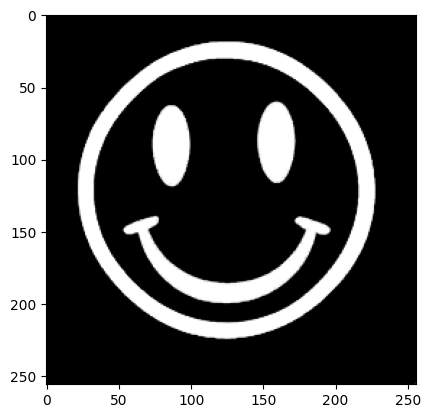

(256, 256)


In [7]:
#Setup and Viz
import cv2
path = "Q2-20251007T170148Z-1-001/Q2/"

smiley_path = os.path.join(path, "smiley.png")
smiley_img = cv2.imread(smiley_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(smiley_img, cmap='gray')
plt.show()
print(smiley_img.shape)

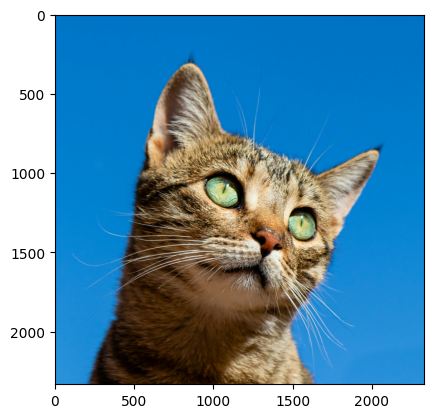

(2333, 2333, 3)


In [8]:
import cv2
path = "Q2-20251007T170148Z-1-001/Q2/"

cat_path = os.path.join(path, "cat.jpg")
cat_img = cv2.imread(cat_path)
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
plt.imshow(cat_img)
plt.show()
print(cat_img.shape)

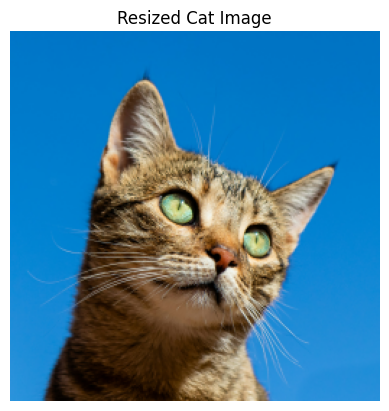

(256, 256, 3)


In [9]:
cat_img = cv2.resize(cat_img, (256, 256), interpolation=cv2.INTER_AREA)
plt.imshow(cat_img)
plt.title("Resized Cat Image")
plt.axis('off')
plt.show()

print(cat_img.shape)

In [10]:
def get_raw(coords):
    return coords

def get_polynomial(coords, order=5):

    if coords.ndim != 2 or coords.shape[1] != 2:
        raise ValueError("Input 'coords' must be a 2D array with 2 columns (x and y).")

    x = coords[:, 0]
    y = coords[:, 1]
    features = []

    for i in range(order + 1):
        for j in range(order + 1):
            if i + j <= order and i + j > 0:
                term = (x ** i) * (y ** j)
                features.append(term)

    return np.stack(features, axis=1)

def get_fourier(coords, freq=10):
    """
    Fourier feature mapping.
    Stack [1, sin(2πfx), cos(2πfx), ..., sin(2πfy), cos(2πfy)]
    Avoids cross-term combinatorial explosion.
    """
    x = coords[:, 0]
    y = coords[:, 1]
    features = [np.ones_like(x)]
    for k in range(1, freq + 1):
        features.append(np.sin(2 * np.pi * k * x))
        features.append(np.cos(2 * np.pi * k * x))
        features.append(np.sin(2 * np.pi * k * y))
        features.append(np.cos(2 * np.pi * k * y))
    return np.stack(features, axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler

def Modular_Dataloader(img, image_type="Gray", method="Raw", order=2, freq=5):
    """
    Generates input features for an MLP from an image array.
    """
    img = img.astype(np.float32)
    y = img / 255.0
    h, w = img.shape[:2]

    coords_grid = np.stack(np.mgrid[0:h, 0:w], axis=-1)
    coords = coords_grid.astype(np.float32) / np.array([h - 1, w - 1])
    coords = coords.reshape(-1, 2)
        
    if method == "Raw":
        X = get_raw(coords)
        
    elif method == "Polynomial":
        poly_features = get_polynomial(coords, order)
        scaler = StandardScaler()
        X = scaler.fit_transform(poly_features)
        
    elif method == "Fourier":
        X = get_fourier(coords, freq)
        
    else:
        raise ValueError("Invalid method. Choose 'Raw', 'Polynomial', or 'Fourier'.")
    
    if image_type == "Gray":
        y = y.flatten()
    else:
        y = y.reshape(-1, 3)
        
    return X.astype(np.float32), y.astype(np.float32)

In [12]:

import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

def train_mlp(features, targets, input_dim, output_dim, hidden_sizes, epochs, 
              batch_size=32, grad_accum_steps=1, lr=0.01,
              patience=None, rel_threshold=0.001,
              save_images=False, img_shape=(256,256), run_name="run"):

    expected_pixels = img_shape[0] * img_shape[1]
    assert features.shape[0] == expected_pixels, \
        f"Features have {features.shape[0]} samples but image needs {expected_pixels}"
    assert targets.shape[0] == expected_pixels, \
        f"Targets have {targets.shape[0]} samples but image needs {expected_pixels}"
    
    print(f"Feature range: [{features.min():.3f}, {features.max():.3f}]")
    print(f"Target range: [{targets.min():.3f}, {targets.max():.3f}]")
    print(f"Training with batch_size={batch_size}, grad_accum_steps={grad_accum_steps}")
    
    layers = []
    dims = [input_dim] + hidden_sizes + [output_dim]
    for i in range(len(dims)-2):
        layers.append(Linear(dims[i], dims[i+1], ReLU()))
    layers.append(Linear(dims[-2], dims[-1], Sigmoid()))
    model = Model(layers, loss_type='mse')
    
    losses = []
    samples_seen = []
    epoch_losses = []
    total_samples = 0
    
    # --- Create folder for saving images ---
    if save_images:
        save_dir = os.path.join("Q2-results", run_name)
        os.makedirs(save_dir, exist_ok=True)
    
    pbar = tqdm(range(epochs), desc="Training", dynamic_ncols=True)
    for epoch in pbar:
        indices = np.random.permutation(len(features))
        shuffled_features = features[indices]
        shuffled_targets = targets[indices]
        
        epoch_loss = 0
        n_batches = 0
        
        # Batch processing
        for i in range(0, len(features), batch_size):
            batch_x = shuffled_features[i:i+batch_size]
            batch_y = shuffled_targets[i:i+batch_size]
            
            # Ensure batch_y has correct shape
            if len(batch_y.shape) == 1:
                batch_y = batch_y.reshape(-1, 1)
            
            loss = model.train(batch_x, batch_y)
            epoch_loss += loss
            n_batches += 1
            total_samples += len(batch_x)
            
            # Update weights after gradient accumulation steps
            if (n_batches % grad_accum_steps) == 0:
                model.update(lr)
            
            losses.append(loss)
            samples_seen.append(total_samples)
        
        # Calculate average epoch loss
        avg_epoch_loss = epoch_loss / n_batches
        epoch_losses.append(avg_epoch_loss)
        
        pbar.set_postfix({"Epoch Loss": f"{avg_epoch_loss:.6f}"})
        
        # --- Save predicted image ---
        # if save_images:
        #     preds = model.forward(features)
        #     pred_img = preds.reshape(img_shape)
        #     pred_img = np.clip(pred_img, 0, 1)
        #     save_path = os.path.join(save_dir, f"epoch_{epoch+1:03d}.png")
        #     plt.imsave(save_path, pred_img, cmap='gray')

        if save_images:
            preds = model.forward(features)
            if output_dim == 3:
                pred_img = preds.reshape(img_shape[0], img_shape[1], 3)
            else:
                pred_img = preds.reshape(img_shape)
            pred_img = np.clip(pred_img, 0, 1)
            save_path = os.path.join(save_dir, f"epoch_{epoch+1:03d}.png")
            if output_dim == 3:
                plt.imsave(save_path, pred_img)
            else:
                plt.imsave(save_path, pred_img, cmap='gray')
        
        if patience is not None and epoch >= patience:
            if epoch_losses[-1] >= (1 - rel_threshold) * epoch_losses[-patience-1]:
                print(f"\nEarly stopping at epoch {epoch+1}")
                print(f"Current loss: {epoch_losses[-1]:.6f}, "
                      f"Loss {patience} epochs ago: {epoch_losses[-patience-1]:.6f}")
                break

        model.save_to(os.path.join(save_dir, "model.npz"))
    
    # --- Save loss vs epoch curve ---
    plt.figure(figsize=(6,4))
    plt.plot(samples_seen, losses, color='b', alpha=0.7)
    plt.title("Loss vs Samples Seen")
    plt.xlabel("Number of Samples Seen")
    plt.ylabel("Training Loss")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "loss_curve.png"), dpi=150)
    plt.close()
    
    return model, losses, epoch_losses

In [13]:
import time

path = "Q2-20251007T170148Z-1-001/Q2/"
smily_image = os.path.join(path, "smiley.png")
cat_image = os.path.join(path, "cat.jpg")
img_shape = (256,256)

architecture = [64, 128, 128]
results = []

#smiley
epochs = 50
features, targets = Modular_Dataloader(smiley_img, image_type="Gray", method="Raw", freq=10)

start = time.time()
smiley_model_raw, smiley_losses_raw, smiley_epoc_losses_raw = train_mlp(features, targets, input_dim=features.shape[1], output_dim=1, hidden_sizes=architecture, epochs=epochs, lr=0.01, save_images=True, img_shape=img_shape, run_name="smiley_raw", batch_size=32, grad_accum_steps=1)
stop = time.time()

results.append({"method":"Raw", "final_loss":smiley_losses_raw[-1], "epoch_time":stop-start, "input_dim":features.shape[1]})

poly_orders = [5, 15, 25]

for order in poly_orders:
    features, targets = Modular_Dataloader(smiley_img, image_type="Gray", method="Polynomial", order=order)

    start = time.time()
    smiley_model_poly, smiley_losses_poly, smiley_epoc_losses_poly = train_mlp(features, targets, input_dim=features.shape[1], output_dim=1, hidden_sizes=architecture, epochs=epochs, lr=0.01, save_images=True, img_shape=img_shape, run_name=f"smiley_poly_{order}", batch_size=32, grad_accum_steps=1)
    stop = time.time()
    results.append({"method":f"Poly_{order}", "final_loss":smiley_losses_poly[-1], "epoch_time":stop-start, "input_dim":features.shape[1]})

fourier_freqs = [5, 15, 25]

for freq in fourier_freqs:
    features, targets = Modular_Dataloader(smiley_img, image_type="Gray", method="Fourier", freq=freq)

    start = time.time()
    smiley_model_fourier, smiley_losses_fourier, smiley_epoc_losses_fourier = train_mlp(features, targets, input_dim=features.shape[1], output_dim=1, hidden_sizes=architecture, epochs=epochs, lr=0.01, save_images=True, img_shape=img_shape, run_name=f"smiley_fourier_{freq}", batch_size=32, grad_accum_steps=1)
    stop = time.time()
    results.append({"method":f"Fourier_{freq}", "final_loss":smiley_losses_fourier[-1], "epoch_time":stop-start, "input_dim":features.shape[1]})


Feature range: [0.000, 1.000]
Target range: [0.000, 1.000]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 50/50 [00:32<00:00,  1.55it/s, Epoch Loss=0.113678]


Feature range: [-1.725, 6.178]
Target range: [0.000, 1.000]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 50/50 [00:31<00:00,  1.60it/s, Epoch Loss=0.013555]


Feature range: [-1.725, 15.707]
Target range: [0.000, 1.000]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 50/50 [00:40<00:00,  1.23it/s, Epoch Loss=0.017710]


Feature range: [-1.725, 24.910]
Target range: [0.000, 1.000]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 50/50 [00:50<00:00,  1.00s/it, Epoch Loss=0.018944]


Feature range: [-1.000, 1.000]
Target range: [0.000, 1.000]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 50/50 [00:32<00:00,  1.54it/s, Epoch Loss=0.002069]


Feature range: [-1.000, 1.000]
Target range: [0.000, 1.000]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 50/50 [00:34<00:00,  1.43it/s, Epoch Loss=0.000733]


Feature range: [-1.000, 1.000]
Target range: [0.000, 1.000]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 50/50 [00:36<00:00,  1.35it/s, Epoch Loss=0.000719]


In [14]:
for res in results:
    print(res)

{'method': 'Raw', 'final_loss': np.float64(0.11705564602330298), 'epoch_time': 32.78305912017822, 'input_dim': 2}
{'method': 'Poly_5', 'final_loss': np.float64(0.02567297162701273), 'epoch_time': 31.545770168304443, 'input_dim': 20}
{'method': 'Poly_15', 'final_loss': np.float64(0.022924426638400892), 'epoch_time': 40.87058067321777, 'input_dim': 135}
{'method': 'Poly_25', 'final_loss': np.float64(0.017768860603629255), 'epoch_time': 50.40032887458801, 'input_dim': 350}
{'method': 'Fourier_5', 'final_loss': np.float64(0.002160400789044819), 'epoch_time': 32.63454461097717, 'input_dim': 21}
{'method': 'Fourier_15', 'final_loss': np.float64(0.0010548044074329926), 'epoch_time': 35.04236316680908, 'input_dim': 61}
{'method': 'Fourier_25', 'final_loss': np.float64(0.0002245786408524398), 'epoch_time': 37.11360764503479, 'input_dim': 101}


In [15]:
import pandas as pd

# Create DataFrame from results
df = pd.DataFrame(results)

# Round numeric columns to 5 decimals
df[['final_loss', 'epoch_time']] = df[['final_loss', 'epoch_time']].round(5)

# Display the table
print(df)


       method  final_loss  epoch_time  input_dim
0         Raw     0.11706    32.78306          2
1      Poly_5     0.02567    31.54577         20
2     Poly_15     0.02292    40.87058        135
3     Poly_25     0.01777    50.40033        350
4   Fourier_5     0.00216    32.63454         21
5  Fourier_15     0.00105    35.04236         61
6  Fourier_25     0.00022    37.11361        101


In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import io

def create_comparison_gif(raw_dir, poly_dir, fourier_dir, raw_losses, poly_losses, fourier_losses, 
                          output_path="comparison.gif", fps=10):
    
    raw_images = sorted(glob.glob(os.path.join(raw_dir, "*.png")))
    poly_images = sorted(glob.glob(os.path.join(poly_dir, "*.png")))
    fourier_images = sorted(glob.glob(os.path.join(fourier_dir, "*.png")))
    
    num_epochs = min(len(raw_images), len(poly_images), len(fourier_images))
    
    frames = []
    
    for i in range(num_epochs):
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        raw_img = Image.open(raw_images[i])
        axes[0].imshow(raw_img, cmap='gray')
        axes[0].set_title(f"Raw - Epoch {i+1}")
        axes[0].axis('off')
        
        ax0_inset = axes[0].inset_axes([0.65, 0.65, 0.3, 0.3])
        ax0_inset.plot(raw_losses[:i+1], 'b-', linewidth=1)
        ax0_inset.set_xlabel('Epoch', fontsize=6)
        ax0_inset.set_ylabel('Loss', fontsize=6)
        ax0_inset.tick_params(labelsize=5)
        ax0_inset.grid(True, alpha=0.3)
        
        poly_img = Image.open(poly_images[i])
        axes[1].imshow(poly_img, cmap='gray')
        axes[1].set_title(f"Polynomial - Epoch {i+1}")
        axes[1].axis('off')
        
        ax1_inset = axes[1].inset_axes([0.65, 0.65, 0.3, 0.3])
        ax1_inset.plot(poly_losses[:i+1], 'g-', linewidth=1)
        ax1_inset.set_xlabel('Epoch', fontsize=6)
        ax1_inset.set_ylabel('Loss', fontsize=6)
        ax1_inset.tick_params(labelsize=5)
        ax1_inset.grid(True, alpha=0.3)
        
        fourier_img = Image.open(fourier_images[i])
        axes[2].imshow(fourier_img, cmap='gray')
        axes[2].set_title(f"Fourier - Epoch {i+1}")
        axes[2].axis('off')
        
        ax2_inset = axes[2].inset_axes([0.65, 0.65, 0.3, 0.3])
        ax2_inset.plot(fourier_losses[:i+1], 'r-', linewidth=1)
        ax2_inset.set_xlabel('Epoch', fontsize=6)
        ax2_inset.set_ylabel('Loss', fontsize=6)
        ax2_inset.tick_params(labelsize=5)
        ax2_inset.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        buf = io.BytesIO()
        plt.savefig(buf, format='png', dpi=100)
        buf.seek(0)
        frames.append(Image.open(buf).copy())
        buf.close()
        
        plt.close(fig)
    
    frames[0].save(output_path, save_all=True, append_images=frames[1:], 
                   duration=1000//fps, loop=0)
    print(f"GIF saved to {output_path}")



In [29]:
raw_dir = "Q2-results/smiley_raw"
poly_dir = "Q2-results/smiley_poly_5"
fourier_dir = "Q2-results/smiley_fourier_5"

raw_losses_array = np.array(smiley_epoc_losses_raw)
poly_losses_array = np.array(smiley_epoc_losses_poly)
fourier_losses_array = np.array(smiley_epoc_losses_fourier)

num_batches_per_epoch = len(smiley_epoc_losses_raw) // 50
epoch_raw_losses = [np.mean(raw_losses_array[i*num_batches_per_epoch:(i+1)*num_batches_per_epoch]) 
                    for i in range(50)]
epoch_poly_losses = [np.mean(poly_losses_array[i*num_batches_per_epoch:(i+1)*num_batches_per_epoch]) 
                     for i in range(50)]
epoch_fourier_losses = [np.mean(fourier_losses_array[i*num_batches_per_epoch:(i+1)*num_batches_per_epoch]) 
                        for i in range(50)]

create_comparison_gif(raw_dir, poly_dir, fourier_dir, 
                     epoch_raw_losses, epoch_poly_losses, epoch_fourier_losses,
                     output_path="smiley_comparison.gif", fps=5)

GIF saved to smiley_comparison.gif


In [15]:
import time

path = "Q2-20251007T170148Z-1-001/Q2/"
smily_image = os.path.join(path, "smiley.png")
cat_image = os.path.join(path, "cat.jpg")
img_shape = (256,256)

architecture = [64, 128, 128]
results = []

#cat
epochs = 150
features, targets = Modular_Dataloader(cat_img, image_type="RGB", method="Raw", freq=10)

start = time.time()
cat_model_raw, cat_losses_raw, cat_epoc_losses_raw = train_mlp(features, targets, input_dim=features.shape[1], output_dim=3, hidden_sizes=architecture, epochs=epochs, lr=0.01, save_images=True, img_shape=img_shape, run_name="cat_raw", batch_size=32, grad_accum_steps=1)
stop = time.time()

results.append({"method":"Raw", "final_loss":cat_losses_raw[-1], "epoch_time":stop-start, "input_dim":features.shape[1]})

poly_orders = [5, 15, 25]

for order in poly_orders:
    features, targets = Modular_Dataloader(cat_img, image_type="RGB", method="Polynomial", order=order)

    start = time.time()
    cat_model_poly, cat_losses_poly, cat_epoc_losses_poly = train_mlp(features, targets, input_dim=features.shape[1], output_dim=3, hidden_sizes=architecture, epochs=epochs, lr=0.01, save_images=True, img_shape=img_shape, run_name=f"cat_poly_{order}", batch_size=32, grad_accum_steps=1)
    stop = time.time()
    results.append({"method":f"Poly_{order}", "final_loss":cat_losses_poly[-1], "epoch_time":stop-start, "input_dim":features.shape[1]})

fourier_freqs = [5, 15, 25]

for freq in fourier_freqs:
    features, targets = Modular_Dataloader(cat_img, image_type="RGB", method="Fourier", freq=freq)

    start = time.time()
    cat_model_fourier, cat_losses_fourier, cat_epoc_losses_fourier = train_mlp(features, targets, input_dim=features.shape[1], output_dim=3, hidden_sizes=architecture, epochs=epochs, lr=0.01, save_images=True, img_shape=img_shape, run_name=f"cat_fourier_{freq}", batch_size=32, grad_accum_steps=1)
    stop = time.time()
    results.append({"method":f"Fourier_{freq}", "final_loss":cat_losses_fourier[-1], "epoch_time":stop-start, "input_dim":features.shape[1]})


Feature range: [0.000, 1.000]
Target range: [0.000, 0.992]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 150/150 [01:33<00:00,  1.61it/s, Epoch Loss=0.010893]


Feature range: [-1.725, 6.178]
Target range: [0.000, 0.992]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 150/150 [01:35<00:00,  1.57it/s, Epoch Loss=0.006336]


Feature range: [-1.725, 15.707]
Target range: [0.000, 0.992]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 150/150 [01:54<00:00,  1.32it/s, Epoch Loss=0.007165]


Feature range: [-1.725, 24.910]
Target range: [0.000, 0.992]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 150/150 [02:23<00:00,  1.05it/s, Epoch Loss=0.007535]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.992]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 150/150 [01:38<00:00,  1.52it/s, Epoch Loss=0.003610]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.992]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 150/150 [01:42<00:00,  1.46it/s, Epoch Loss=0.002743]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.992]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 150/150 [01:52<00:00,  1.34it/s, Epoch Loss=0.002394]


In [16]:
for res in results:
    print(res)

{'method': 'Raw', 'final_loss': np.float64(0.01372105617804821), 'epoch_time': 93.66616868972778, 'input_dim': 2}
{'method': 'Poly_5', 'final_loss': np.float64(0.008868924994229728), 'epoch_time': 95.55254173278809, 'input_dim': 20}
{'method': 'Poly_15', 'final_loss': np.float64(0.008291072157353271), 'epoch_time': 114.37438321113586, 'input_dim': 135}
{'method': 'Poly_25', 'final_loss': np.float64(0.002400114836133935), 'epoch_time': 143.82730078697205, 'input_dim': 350}
{'method': 'Fourier_5', 'final_loss': np.float64(0.007358059702489911), 'epoch_time': 98.6220600605011, 'input_dim': 21}
{'method': 'Fourier_15', 'final_loss': np.float64(0.0025614721647466182), 'epoch_time': 102.97377109527588, 'input_dim': 61}
{'method': 'Fourier_25', 'final_loss': np.float64(0.0034833130704695105), 'epoch_time': 112.46357274055481, 'input_dim': 101}


In [17]:
raw_dir = "Q2-results/cat_raw"
poly_dir = "Q2-results/cat_poly_5"
fourier_dir = "Q2-results/cat_fourier_5"

raw_losses_array = np.array(cat_epoc_losses_raw)
poly_losses_array = np.array(cat_epoc_losses_poly)
fourier_losses_array = np.array(cat_epoc_losses_fourier)

num_batches_per_epoch = len(cat_epoc_losses_raw) // 50
epoch_raw_losses = [np.mean(raw_losses_array[i*num_batches_per_epoch:(i+1)*num_batches_per_epoch]) 
                    for i in range(50)]
epoch_poly_losses = [np.mean(poly_losses_array[i*num_batches_per_epoch:(i+1)*num_batches_per_epoch]) 
                     for i in range(50)]
epoch_fourier_losses = [np.mean(fourier_losses_array[i*num_batches_per_epoch:(i+1)*num_batches_per_epoch]) 
                        for i in range(50)]

create_comparison_gif(raw_dir, poly_dir, fourier_dir, 
                     epoch_raw_losses, epoch_poly_losses, epoch_fourier_losses,
                     output_path="cat_comparison.gif", fps=5)

GIF saved to cat_comparison.gif


In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm

blur_path = "Q2-20251007T170148Z-1-001/Q2/blurred/"
img_shape = (256, 256)
architecture = [64, 128, 128]
max_epochs = 100

base_results = []
fourier_results = []

import os
print(os.listdir(blur_path))


for blur_idx in range(10):
    img_path = os.path.join(blur_path, f"blur_{blur_idx}.png")
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, img_shape, interpolation=cv2.INTER_AREA)
    
    print(f"\n=== Processing blur_{blur_idx}.jpg ===")
    
    features_base, targets = Modular_Dataloader(img, image_type="RGB", method="Raw")
    model_base, losses_base, epoch_losses_base = train_mlp(
        features_base, targets, 
        input_dim=features_base.shape[1], 
        output_dim=3,
        hidden_sizes=architecture, 
        epochs=max_epochs, 
        lr=0.01,
        patience=10,
        rel_threshold=0.001,
        save_images=True, 
        img_shape=img_shape, 
        run_name=f"blur_{blur_idx}_base",
        batch_size=32
    )
    base_results.append(epoch_losses_base[-1])
    
    features_fourier, targets = Modular_Dataloader(img, image_type="RGB", method="Fourier", freq=5)
    model_fourier, losses_fourier, epoch_losses_fourier = train_mlp(
        features_fourier, targets,
        input_dim=features_fourier.shape[1],
        output_dim=3,
        hidden_sizes=architecture,
        epochs=max_epochs,
        lr=0.01,
        patience=10,
        rel_threshold=0.001,
        save_images=True,
        img_shape=img_shape,
        run_name=f"blur_{blur_idx}_fourier",
        batch_size=32
    )
    fourier_results.append(epoch_losses_fourier[-1])



libpng warning: iCCP: known incorrect sRGB profile


['blur_4.png', 'blur_1.png', 'blur_9.png', 'blur_5.png', 'blur_2.png', 'blur_8.png', 'blur_3.png', 'blur_6.png', 'blur_7.png', 'blur_0.png']

=== Processing blur_0.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.984]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:02<00:00,  1.59it/s, Epoch Loss=0.011508]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.984]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s, Epoch Loss=0.003536]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_1.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.957]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s, Epoch Loss=0.009228]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.957]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s, Epoch Loss=0.001656]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_2.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.933]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s, Epoch Loss=0.006230]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.933]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:03<00:00,  1.56it/s, Epoch Loss=0.000869]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_3.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.906]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s, Epoch Loss=0.004044]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.906]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:03<00:00,  1.57it/s, Epoch Loss=0.000612]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_4.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.886]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s, Epoch Loss=0.002919]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.886]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s, Epoch Loss=0.000539]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_5.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:01<00:00,  1.63it/s, Epoch Loss=0.002329]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:04<00:00,  1.56it/s, Epoch Loss=0.000521]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_6.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:02<00:00,  1.61it/s, Epoch Loss=0.001596]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:03<00:00,  1.56it/s, Epoch Loss=0.000498]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_7.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s, Epoch Loss=0.001550]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:03<00:00,  1.56it/s, Epoch Loss=0.000486]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_8.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:01<00:00,  1.62it/s, Epoch Loss=0.001051]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:10<00:00,  1.42it/s, Epoch Loss=0.000450]
libpng warning: iCCP: known incorrect sRGB profile



=== Processing blur_9.jpg ===
Feature range: [0.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:04<00:00,  1.55it/s, Epoch Loss=0.000827]


Feature range: [-1.000, 1.000]
Target range: [0.000, 0.859]
Training with batch_size=32, grad_accum_steps=1


Training: 100%|██████████| 100/100 [01:07<00:00,  1.49it/s, Epoch Loss=0.000446]


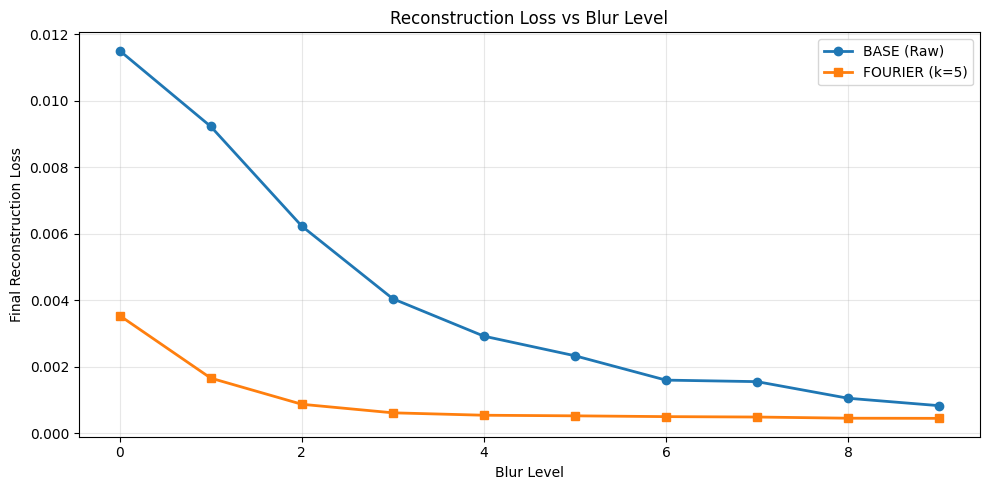

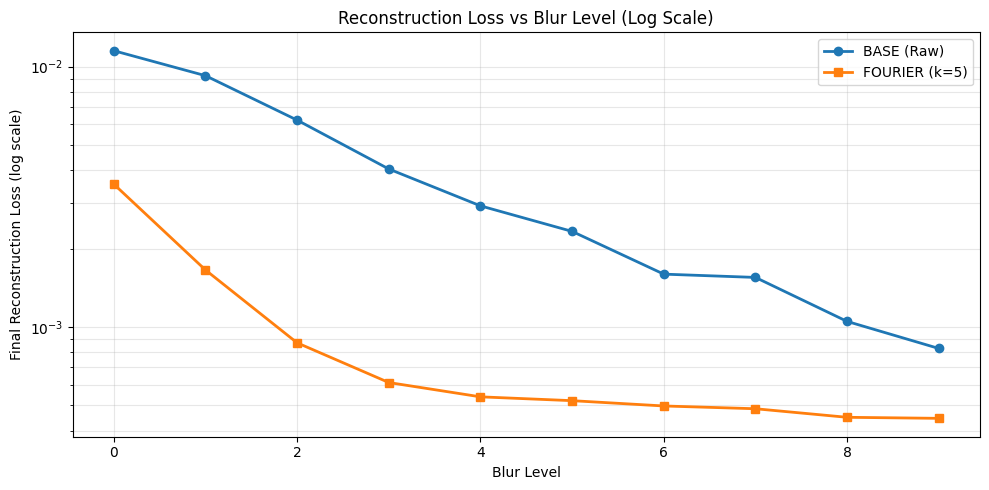


=== Results Summary ===
Blur 0: BASE=0.011508, FOURIER=0.003536
Blur 1: BASE=0.009228, FOURIER=0.001656
Blur 2: BASE=0.006230, FOURIER=0.000869
Blur 3: BASE=0.004044, FOURIER=0.000612
Blur 4: BASE=0.002919, FOURIER=0.000539
Blur 5: BASE=0.002329, FOURIER=0.000521
Blur 6: BASE=0.001596, FOURIER=0.000498
Blur 7: BASE=0.001550, FOURIER=0.000486
Blur 8: BASE=0.001051, FOURIER=0.000450
Blur 9: BASE=0.000827, FOURIER=0.000446


In [15]:
blur_levels = np.arange(10)

plt.figure(figsize=(10, 5))
plt.plot(blur_levels, base_results, 'o-', label='BASE (Raw)', linewidth=2)
plt.plot(blur_levels, fourier_results, 's-', label='FOURIER (k=5)', linewidth=2)
plt.xlabel('Blur Level')
plt.ylabel('Final Reconstruction Loss')
plt.title('Reconstruction Loss vs Blur Level')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('blur_reconstruction_linear.png', dpi=150)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(blur_levels, base_results, 'o-', label='BASE (Raw)', linewidth=2)
plt.plot(blur_levels, fourier_results, 's-', label='FOURIER (k=5)', linewidth=2)
plt.xlabel('Blur Level')
plt.ylabel('Final Reconstruction Loss (log scale)')
plt.title('Reconstruction Loss vs Blur Level (Log Scale)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3, which='both')
plt.tight_layout()
plt.savefig('blur_reconstruction_log.png', dpi=150)
plt.show()

print("\n=== Results Summary ===")
for i in range(10):
    print(f"Blur {i}: BASE={base_results[i]:.6f}, FOURIER={fourier_results[i]:.6f}")